In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
def circle_shift(numpy_array, shift=1):
    return np.concatenate((numpy_array[shift:], numpy_array[:shift]), axis=0)

class TorchGMM1D():
    def __init__(self, data_input, data_label, nodes=1, period=None):
        if not (period is None):
            if data_input.max() > period or data_input.max() < 0:
                raise ValueError("data_input range error, expect 0 to %d, got %d to %d" %(period,
                                                                                          data_input.min(),
                                                                                          data_input.max()
                                                                                         )
                                )
            
            self.periodic=True
        else:
            self.periodic=False
        
        self.data_input = data_input
        self.data_label = data_label
        self.nodes = nodes
        
        amp_max = data_label.max()
        self.log_amp = torch.autograd.Variable(torch.rand((nodes))-1-torch.log(amp_max), requires_grad=True)
        
        m = data_input.min()
        M = data_input.max()
        
        center = 0.5/nodes + torch.arange((nodes)).type(torch.FloatTensor)/nodes
        center = (M-m)*center + m
        self.center = torch.autograd.Variable(center, requires_grad=True)
        
        var = (2*torch.rand((nodes)) - 1)**2
        self.var_log = torch.autograd.Variable(torch.log(var), requires_grad=True)
        
        self.var_log_bias = np.log(0.5/(self.nodes))
    
    def forward(self):
        x = self.data_input.view(-1,1).repeat(1,self.nodes)
        x = x - self.center        
        x = x*x
        var = torch.exp(self.var_log + self.var_log_bias)
        x = -(0.5)*x/var
        x = torch.exp(x)
        #x = self.amplitude*x
        x = torch.exp(self.log_amp)*x
        x = x.sum(dim=1)
        return x
    
    def fit(self, epoch, lr=1e-2, betas=(0.9, 0.999), weight_decay=0, connected_penalty=None, out_penalty=0.0001):
        self.optimizer = torch.optim.Adam([self.log_amp, self.center, self.var_log],
                                          lr=lr, betas=betas, weight_decay=weight_decay)
        self.criterion = torch.nn.MSELoss()
        m = self.data_input.min()
        M = self.data_input.max()
        for e in range(epoch):
            self.optimizer.zero_grad()
            loss = self.criterion(self.forward(), self.data_label)
            if not (connected_penalty is None):
                std = torch.exp(0.5*(self.var_log + self.var_log_bias))
                dis_mat = self.center.view(self.nodes,1).repeat(1,self.nodes)
                dis_mat = ((dis_mat - self.center)/std)**2 + 0.001
                penalty = (torch.ones(self.nodes, self.nodes) - torch.eye(self.nodes))/dis_mat
                loss += connected_penalty*(penalty.sum())
            
            if not (out_penalty is None):
                penalty = (self.center-m)/(M-m)
                penalty = torch.nn.functional.softplus(penalty-1) + torch.nn.functional.softplus(-penalty)
                penalty = penalty**2
                loss += out_penalty*(penalty.sum())
            
            loss.backward()
            self.optimizer.step()

class ContourAnalysis():
    def __init__(self, contour, filled=True, filled_threshold=1., mean_radius=5, curvature_radius=3):
        """
        contour : (n,2) numpy array, order contour
        filled : bool, If true, filled contour if interval larger then filled_threshold
        filled_threshold : float > 0, threshold used to filled contour
        mean_radius : non-negative int, compute mean tangent vector of i-th point by i-mean_radius to i+mean_radius points
        curvature_radius : positive int, compute curvature of i-th point by i-curvature_radius and i+curvature_radius points
        """
        if filled:
            distance2next_point = np.linalg.norm(circle_shift(contour) - contour, axis=1)
            self.contour = np.zeros((0,2))
            for t in range(len(contour)-1):
                if distance2next_point[t] == 0.:
                    continue
                
                interp_weight = np.arange(np.ceil(distance2next_point[t])) / np.ceil(distance2next_point[t])
                interp_point = np.dot(1 - interp_weight.reshape(-1,1), contour[t:t+1]) + np.dot(interp_weight.reshape(-1,1), contour[t+1:t+2])
                self.contour = np.concatenate((self.contour, interp_point), axis = 0)
            
            # case for end point
            if distance2next_point[-1] == 0.:
                pass
            
            interp_weight = np.arange(np.ceil(distance2next_point[-1])) / np.ceil(distance2next_point[-1])
            interp_point = np.dot(1 - interp_weight.reshape(-1,1), contour[-1:]) + np.dot(interp_weight.reshape(-1,1), contour[:1])
            self.contour = np.concatenate((self.contour, interp_point), axis = 0)
        else:
            self.contour = contour
        
        self.tangent = circle_shift(self.contour, mean_radius) - circle_shift(self.contour, -mean_radius)
        tangent_len = np.linalg.norm(self.tangent, axis=1)
        self.tangent[:,0] /= tangent_len + 0.000001
        self.tangent[:,1] /= tangent_len + 0.000001
        
        self.curvature = np.zeros((len(self.contour)))
        start_tangent = circle_shift(self.tangent, -curvature_radius)
        end_tangent = circle_shift(self.tangent, curvature_radius)
        obtuse_angle = ((end_tangent[:,0]*start_tangent[:,0] + end_tangent[:,1]*start_tangent[:,1]) < 0.)
        radian_diff = np.arcsin(np.cross(start_tangent, end_tangent))
        radian_diff[obtuse_angle] = np.pi - (radian_diff[obtuse_angle]%(2*np.pi))
        self.curvature = radian_diff/(2*curvature_radius)
        """
        computing curvature by tangent vector
        get radian difference between two tangent vector by cross product and arcsin
        verify obtuse angle by inner product(range of arcsin is -pi/2 to pi/2)
        """
        
    
    def draw(self):
        for i in range(len(self.contour)):
            tangent_line = np.dot((np.arange(15).reshape(-1,1)-7)/2, self.tangent[i:i+1]) + self.contour[i]
            plt.plot(tangent_line[:,0], tangent_line[:,1])
        
        plt.plot(self.contour[:,0], self.contour[:,1])
        plt.show()

In [3]:
foo = ContourAnalysis(np.array([[0,0], [40,20], [20,40], [40,60], [0,80]]), mean_radius=3)

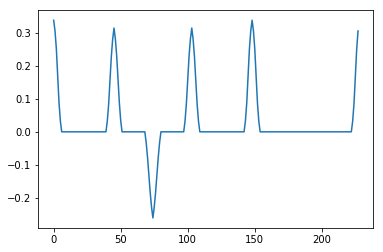

In [4]:
plt.plot(foo.curvature)
plt.show()

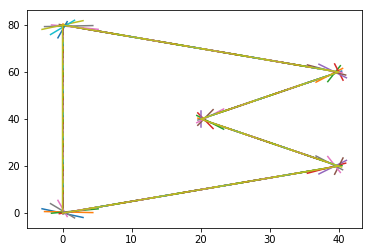

In [5]:
foo.draw()

In [19]:
range01 = torch.arange(len(foo.contour)).type(torch.FloatTensor)/len(foo.contour)
labels = torch.tensor(circle_shift(foo.curvature, -20)).type(torch.FloatTensor)
gmm = TorchGMM1D(data_input=range01, data_label=labels, nodes=4)

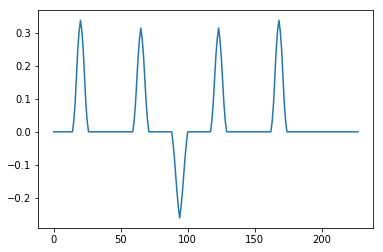

In [20]:
plt.plot(circle_shift(foo.curvature, -20))
plt.show()

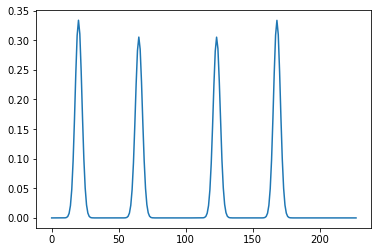

In [22]:
gmm.fit(epoch=1000, lr=0.01, betas=(0.9, 0.99), weight_decay=0.00001, connected_penalty=0.0001, out_penalty=0.01)
plt.plot(gmm.forward().data)
plt.show()

In [53]:
gmm.center

tensor([0.1174, 0.6830, 1.2239, 1.5696], requires_grad=True)

In [27]:
gmm.log_amp

tensor([0.8605, 0.1721, 0.4406, 0.8280])

In [28]:
gmm.var_log

tensor([-1.6462, -1.5806, -1.3907, -1.2190], requires_grad=True)

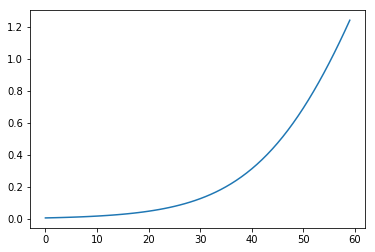

In [205]:
arange = (torch.arange(60) - 30).type(torch.FloatTensor)/10
plt.plot((torch.nn.functional.softplus(arange-2.)))
plt.show()

tensor([-2.0000, -1.9000, -1.8000, -1.7000, -1.6000, -1.5000, -1.4000, -1.3000,
        -1.2000, -1.1000, -1.0000, -0.9000, -0.8000, -0.7000, -0.6000, -0.5000,
        -0.4000, -0.3000, -0.2000, -0.1000,  0.0000,  0.1000,  0.2000,  0.3000,
         0.4000,  0.5000,  0.6000,  0.7000,  0.8000,  0.9000,  1.0000,  1.1000,
         1.2000,  1.3000,  1.4000,  1.5000,  1.6000,  1.7000,  1.8000,  1.9000])